In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import torch

from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

GOLD_PARQUET_PATH = '/Users/olievortex/lakehouse/default/Files/gold/igra2/liftedindex_lr'
ARTIFACTS_PATH = '/Users/olievortex/lakehouse/default/Files/gold/igra2/artifacts'

epochs = 32
batch_size = 32
learning_rate = 0.001
learning_rate_gamma = 0.90

In [2]:
def load_dataset():
    df = pd.read_parquet(GOLD_PARQUET_PATH)

    # Separate the datasets
    X = df.drop(['id', 'effective_date', 'hour', 'li'], axis=1)
    Y = df['li'].values
        
    # Scale the X dataset
    ss = StandardScaler() 
    X = ss.fit_transform(X)
    with open(f'{ARTIFACTS_PATH}/li_std_scaler.skl', 'wb') as f:
        pickle.dump(ss, f)
   
    return train_test_split(X, Y, test_size=0.2)

In [3]:
x_train, x_test, y_train, y_test = load_dataset()

In [4]:
_, D =x_train.shape
K = 1

print(f"D: {D}, K: {K}")

D: 127, K: 1


In [5]:
model = torch.nn.Sequential()

model.add_module("dense1", torch.nn.Linear(D, 7))
model.add_module("tanh1", torch.nn.Tanh())
model.add_module("dense2", torch.nn.Linear(7, K))

In [6]:
loss = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=learning_rate_gamma)

In [7]:
def train(model, loss, optimizer, inputs, labels):
    optimizer.zero_grad()

    logits = model.forward(inputs)
    output = loss.forward(logits, labels)
    output.backward()
    optimizer.step()

    return output.item()

def predict(model, inputs):
    logits = model.forward(inputs)
    return logits.data.numpy()

def make_graph(y_test, y_pred):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

    ax1.title.set_text('Interesting Region')
    ax1.scatter(y_test, y_pred)
    ax1.plot((-14, 50), (-14, 50), c='k')
    ax1.set_xlabel('actual')
    ax1.set_ylabel('prediction')
    ax1.set_ylim(-14, 6)
    ax1.set_xlim(-14, 6)

    ax2.title.set_text('Full Region')
    ax2.scatter(y_test, y_pred)
    ax2.plot((-14, 50), (-14, 50), c='k')
    ax2.set_xlabel('actual')
    ax2.set_ylabel('prediction')

    plt.show()

In [8]:
x_train = torch.from_numpy(x_train).float()
y_train = torch.from_numpy(y_train).float()
x_test = torch.from_numpy(x_test).float()

n_batches = x_train.size()[0] // batch_size
costs = []
test_accuracies = []

In [9]:
for i in range(epochs):
    cost = 0

    for j in range(n_batches):
        x_batch = x_train[j * batch_size:(j+1) * batch_size]
        y_batch = y_train[j * batch_size:(j+1) * batch_size].view(-1, 1)
        cost += train(model, loss, optimizer, x_batch, y_batch)

    y_pred = predict(model, x_test)
    acc = r2_score(y_pred, y_test)
    scheduler.step()

    print(f"Epoch: {i}, cost: {cost / n_batches:.4f}, acc: {acc:.3f}, lr: {scheduler.get_last_lr()[0]:.2e}")

    costs.append(cost / n_batches)
    test_accuracies.append(acc)

Epoch: 0, cost: 23.2173, acc: 0.990, lr: 9.00e-04
Epoch: 1, cost: 0.5236, acc: 0.997, lr: 8.10e-04
Epoch: 2, cost: 0.2856, acc: 0.998, lr: 7.29e-04
Epoch: 3, cost: 0.2387, acc: 0.998, lr: 6.56e-04
Epoch: 4, cost: 0.2137, acc: 0.998, lr: 5.90e-04
Epoch: 5, cost: 0.1980, acc: 0.998, lr: 5.31e-04
Epoch: 6, cost: 0.1878, acc: 0.998, lr: 4.78e-04
Epoch: 7, cost: 0.1798, acc: 0.998, lr: 4.30e-04
Epoch: 8, cost: 0.1731, acc: 0.998, lr: 3.87e-04
Epoch: 9, cost: 0.1673, acc: 0.998, lr: 3.49e-04
Epoch: 10, cost: 0.1623, acc: 0.998, lr: 3.14e-04
Epoch: 11, cost: 0.1578, acc: 0.998, lr: 2.82e-04
Epoch: 12, cost: 0.1538, acc: 0.998, lr: 2.54e-04
Epoch: 13, cost: 0.1503, acc: 0.999, lr: 2.29e-04
Epoch: 14, cost: 0.1471, acc: 0.999, lr: 2.06e-04
Epoch: 15, cost: 0.1442, acc: 0.999, lr: 1.85e-04
Epoch: 16, cost: 0.1417, acc: 0.999, lr: 1.67e-04
Epoch: 17, cost: 0.1394, acc: 0.999, lr: 1.50e-04
Epoch: 18, cost: 0.1374, acc: 0.999, lr: 1.35e-04
Epoch: 19, cost: 0.1356, acc: 0.999, lr: 1.22e-04
Epoch: 20

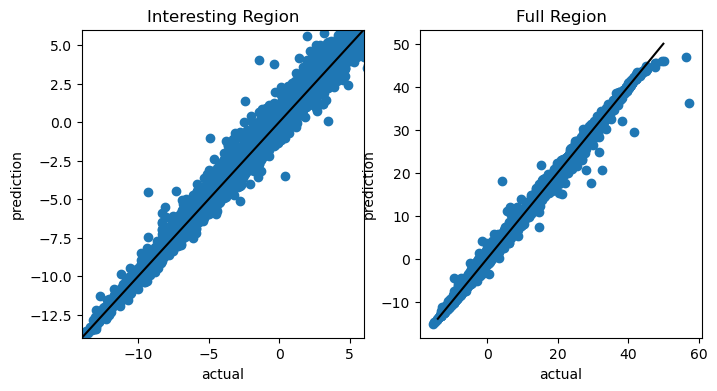

In [10]:
make_graph(y_test, y_pred)

In [11]:
torch.save(model.state_dict(), f'{ARTIFACTS_PATH}/li_fnn.pt')